In [1]:
import matplotlib.pyplot as plt
import numpy as np
import re
import matplotlib
%matplotlib notebook
import pandas as pd

import matplotlib as mpl
mpl.rcParams['axes.formatter.useoffset'] = False


import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn

def density_scatter(x, y, bins=50, xlim=None, ylim=None, filename=None):
    fig = plt.figure(figsize=(10, 10))
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    plt.clf()
    plt.imshow(heatmap.T, extent=extent, origin='lower')
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)
    if filename is not None:
        plt.savefig(filename)
    plt.show()
    
import matplotlib.animation as animation

In [2]:
def get_image_data(filename, gamma=0.6, debug=False, hide_max=False, logscale=False):
    with open(filename, "rb") as f:
        image_size = np.fromfile(f, dtype=np.int32, count=2)
        extent = np.fromfile(f, dtype=np.float32, count=4)
        image = np.fromfile(f, dtype=np.int32).reshape(image_size).T.astype(np.float)

        if (debug):
            _all = image.shape[0] * image.shape[1]
            _z = image[image == 0].shape[0]
            print(f"{filename}")
            print(f"\tzeros: {_z} ({100 * _z/_all}%)")
            print(f"\tmean & std: {np.mean(image)} +- {np.std(image)}")
            print(f"\ttotal_rays: {np.sum(image)}")

        img = np.zeros_like(image)
        if gamma is not None:
            img[image > 0] = image[image > 0]**gamma
        if logscale is not None and logscale:
            img[image > 0] = np.log10(image[image > 0])
        if img[img == np.max(img)].shape[0] < 5 and hide_max:
            img[img == np.max(img)] = np.mean(img) # removing center-of-mass pixel with extreame amplification
        return img, extent

def get_lc_data(filename):
    data = np.loadtxt(filename)
    return pd.DataFrame(data=data.copy(), columns=["y1", "y2", "n_ad", "a_ad",  "n_gs", "a_gs",  "n_ld", "a_ld", "n_pl", "a_pl"])

In [171]:
rays_y = np.loadtxt("./output/test/rays_0.00.dat")

<IPython.core.display.Javascript object>


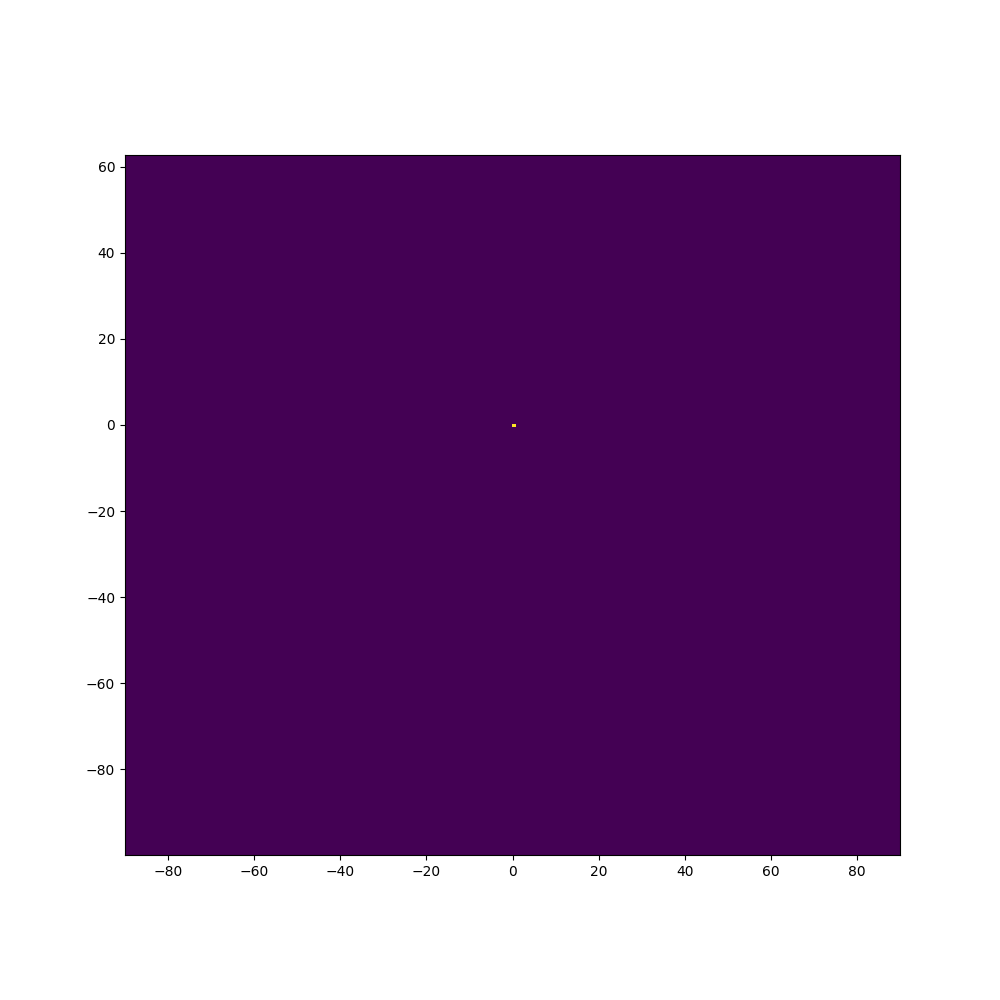

In [172]:
m = np.logical_and(np.abs(rays_y[:,0]) <= 100, np.abs(rays_y[:,1]) <= 100)
x = rays_y[:,0][m]
y = rays_y[:,1][m]
density_scatter(x, y, bins=[200, 200])

output/test/image_0.00.dat
	zeros: 504964 (50.4964%)
	mean & std: 50.264787 +- 52.34491456526251
	total_rays: 50264787.0
output/test/image_0.00.dat
	zeros: 504964 (50.4964%)
	mean & std: 50.264787 +- 52.34491456526251
	total_rays: 50264787.0


<IPython.core.display.Javascript object>


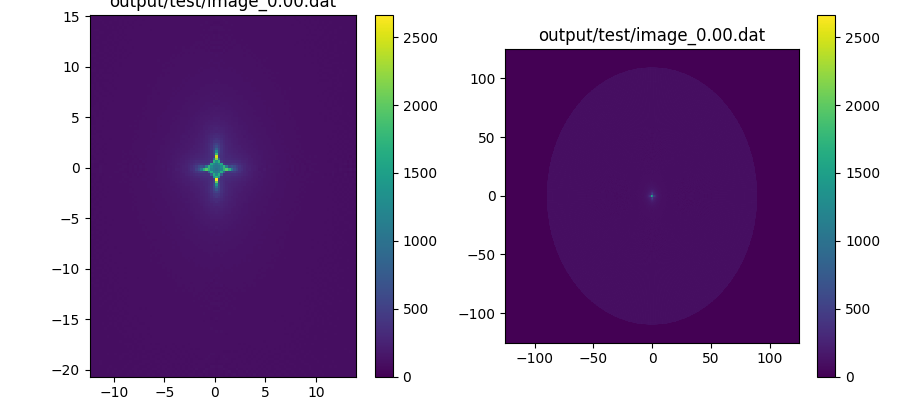

In [38]:
filename1 = "output/test/image_0.00.dat"
filename2 = "output/test/image_0.00.dat"

img1, extent1 = get_image_data(filename1, gamma=1, debug=True)
img2, extent2 = get_image_data(filename2, gamma=1, debug=True)

fig, (ax1, ax2) = plt.subplots(figsize=(9,4), ncols=2)
pos1 = ax1.imshow(img1, interpolation='none', extent=extent1, origin='lower')
pos2 = ax2.imshow(img2, interpolation='none', extent=extent2, origin='lower')
ax1.set_title(filename1)
ax2.set_title(filename2)
fig.colorbar(pos1, ax=ax1)
fig.colorbar(pos2, ax=ax2)
fig.tight_layout()
plt.show()

output/reference/image_0.00.dat
	zeros: 500668 (50.0668%)
	mean & std: 0.664888 +- 0.8913977492993799
	total_rays: 664888.0


<IPython.core.display.Javascript object>


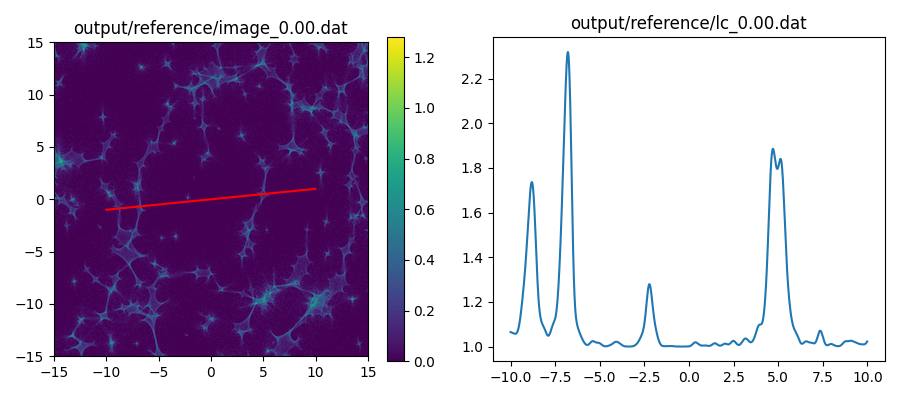

In [136]:
filename1 = "output/reference/image_0.00.dat"
filename2 = "output/reference/lc_0.00.dat"

img1, extent1 = get_image_data(filename1, logscale=True, debug=True)
lc = get_lc_data(filename2)

fig, (ax1, ax2) = plt.subplots(figsize=(9,4), ncols=2)
pos1 = ax1.imshow(img1, interpolation='bessel', extent=extent1, origin='lower')
ax1.plot(lc['y1'], lc['y2'], color='red')
pos2 = ax2.plot(lc['y1'], lc['a_gs']/lc['n_gs'], '-')
#pos2 = ax2.plot(lc['y1'], lc['norm'], '-')
#pos2 = ax2.plot(lc['y1'], lc['ampl'], '-')
ax1.set_title(filename1)
ax2.set_title(filename2)
fig.colorbar(pos1, ax=ax1)
fig.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


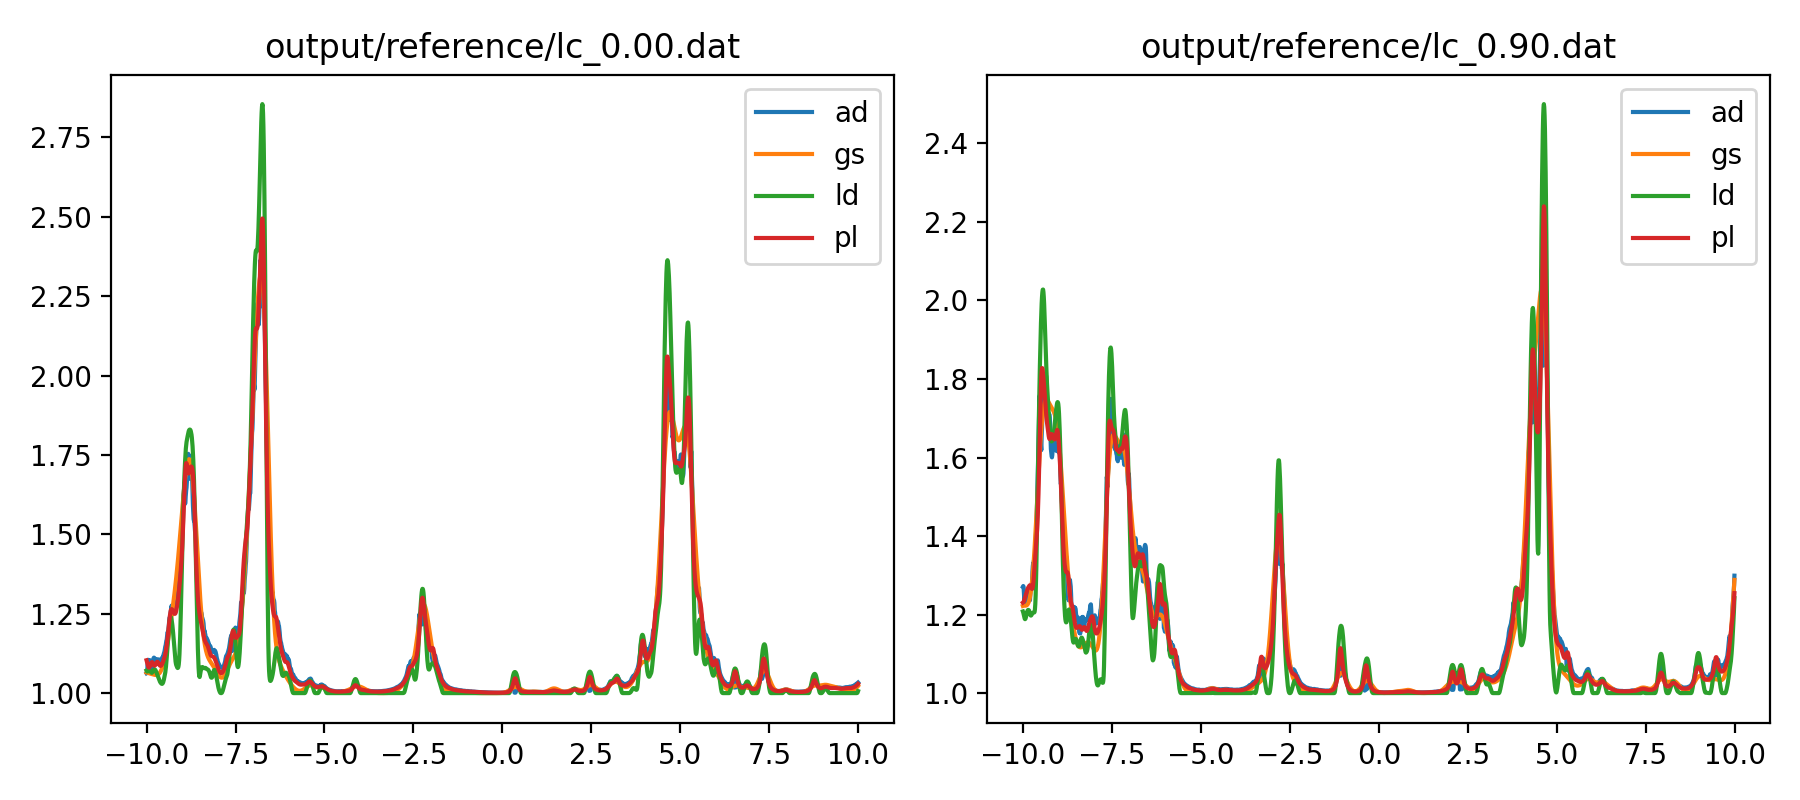

In [66]:
filename1 = "output/reference/lc_0.00.dat"
filename2 = "output/reference/lc_0.90.dat"

lc1 = get_lc_data(filename1)
lc2 = get_lc_data(filename2)

fig, (ax1, ax2) = plt.subplots(figsize=(9,4), ncols=2)
pos1 = ax1.plot(lc1['y1'], lc1['a_ad']/lc1['n_ad'], '-', label='ad')
ax1.plot(lc1['y1'], lc1['a_gs']/lc1['n_gs'], '-', label='gs')
ax1.plot(lc1['y1'], lc1['a_ld']/lc1['n_ld'], '-', label='ld')
ax1.plot(lc1['y1'], lc1['a_pl']/lc1['n_pl'], '-', label='pl')
ax1.legend()

pos2 = ax2.plot(lc2['y1'], lc2['a_ad']/lc2['n_ad'], '-', label='ad')
ax2.plot(lc2['y1'], lc2['a_gs']/lc2['n_gs'], '-', label='gs')
ax2.plot(lc2['y1'], lc2['a_ld']/lc2['n_ld'], '-', label='ld')
ax2.plot(lc2['y1'], lc2['a_pl']/lc2['n_pl'], '-', label='pl')
ax2.legend()

ax1.set_title(filename1)
ax2.set_title(filename2)
fig.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


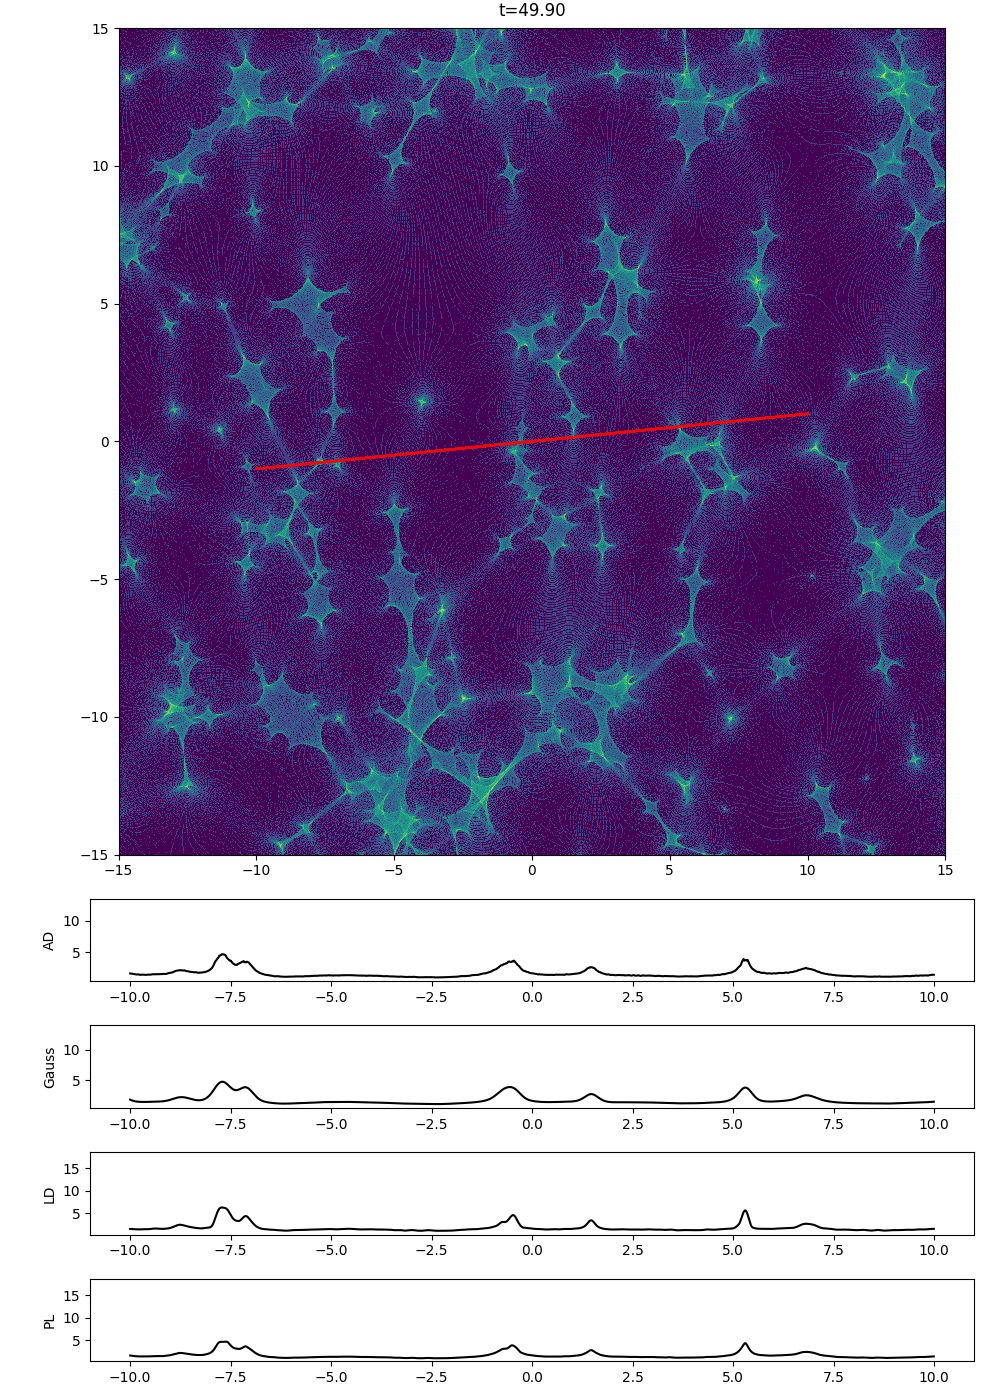

t=0.00
t=1.00
t=2.00
t=3.00
t=4.00
t=5.00
t=6.00
t=7.00
t=8.00
t=9.00
t=10.00
t=11.00
t=12.00
t=13.00
t=14.00
t=15.00
t=16.00
t=17.00
t=18.00
t=19.00
t=20.00
t=21.00
t=22.00
t=23.00
t=24.00
t=25.00
t=26.00
t=27.00
t=28.00
t=29.00
t=30.00
t=31.00
t=32.00
t=33.00
t=34.00
t=35.00
t=36.00
t=37.00
t=38.00
t=39.00
t=40.00
t=41.00
t=42.00
t=43.00
t=44.00
t=45.00
t=46.00
t=47.00
t=48.00
t=49.00


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
    
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5,1, figsize=(10, 14), gridspec_kw={'height_ratios': [10, 1, 1, 1, 1]})
fig.tight_layout()
fig.subplots_adjust(left=0.09, top=0.98)

ims = []
max_ampl = []
s_ad_max = 0
s_gs_max = 0
s_ld_max = 0
s_pl_max = 0
for t in np.arange(0, 50, 0.1):
    if 10 * t % 10 == 0:
        print("t=%.2f" % t)
    filename1 = "output/test/image_%.2f.dat" % t
    filename2 = "output/test/lc_%.2f.dat" % t
    img, extent = get_image_data(filename1, logscale=True)
    lc = get_lc_data(filename2)
    title = ax1.text(0.5,1.01, "t=%.2f" % t, ha="center",va="bottom", transform=ax1.transAxes, fontsize="large")
    line1 = ax1.imshow(img, interpolation='none', extent=extent, origin='lower')
    ax1.plot(lc['y1'], lc['y2'], color='red')
    
    s_ad = lc['a_ad']/lc['n_ad']
    line2, = ax2.plot(lc['y1'], s_ad, '-', color='black')
    ax2.set_ylabel('AD')
    if max(s_ad) > s_ad_max: s_ad_max = max(s_ad)
        
    s_gs = lc['a_gs']/lc['n_gs']
    line3, = ax3.plot(lc['y1'], s_gs, '-', color='black')
    ax3.set_ylabel('Gauss')
    if max(s_gs) > s_gs_max: s_gs_max = max(s_gs)

    s_ld = lc['a_ld']/lc['n_ld']
    line4, = ax4.plot(lc['y1'], s_ld, '-', color='black')
    ax4.set_ylabel('LD')
    if max(s_ld) > s_ld_max: s_ld_max = max(s_ld)

    s_pl = lc['a_pl']/lc['n_pl']
    line5, = ax5.plot(lc['y1'], s_pl, '-', color='black')
    ax5.set_ylabel('PL')
    if max(s_pl) > s_pl_max: s_pl_max = max(s_ld)

    ims.append([line1, line2, line3, line4, line5, title])

for l in ims:
    _l1, _l2, _l3, _l4, _l5, _t = l
    _l2.axes.set_ylim([None, 1.05 * s_ad_max])
    _l3.axes.set_ylim([None, 1.05 * s_gs_max])
    _l4.axes.set_ylim([None, 1.05 * s_ld_max])
    _l5.axes.set_ylim([None, 1.05 * s_pl_max])

ani = animation.ArtistAnimation(fig, ims, interval=200, blit=True, repeat=False)
ani.save('images/dynamic_images.mp4')
plt.show()